In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# Use SQLAlchemy `create_engine` to connect to your sqlite database.

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

##### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [10]:
conn = engine.connect()
measurements = pd.read_sql("Select * From Measurement" ,conn)
measurements.head()
measurements.dtypes

#changing date coulmn to datetime format
measurements['date'] = pd.to_datetime(measurements['date'])
measurements.dtypes
measurements.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


##### Calculate the date 1 year ago from the last data point in the database

In [11]:
twelve_months_ago = measurements['date'].max() - pd.DateOffset(months=12)
print(f"The date 12 months ago was {twelve_months_ago}")

The date 12 months ago was 2016-08-23 00:00:00


###### Perform a query to retrieve the data and precipitation scores


In [12]:
twelve_month_data = measurements.loc[measurements['date'] >= twelve_months_ago]
tmd = twelve_month_data[['date','prcp']]
tmd.head()

,date,prcp
2363,2016-08-23,0.00
2364,2016-08-24,0.08
2365,2016-08-25,0.08
2366,2016-08-26,0.00
2367,2016-08-27,0.00


##### Save the query results as a Pandas DataFrame and set the index to the date column


In [13]:
twelve = pd.DataFrame(tmd)
twelve = twelve.set_index('date')
twelve.sort_index()
twelve.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


##### Sort the dataframe by date


In [14]:
twelve = twelve.sort_index()
twelve.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


##### Use Pandas Plotting with Matplotlib to plot the data


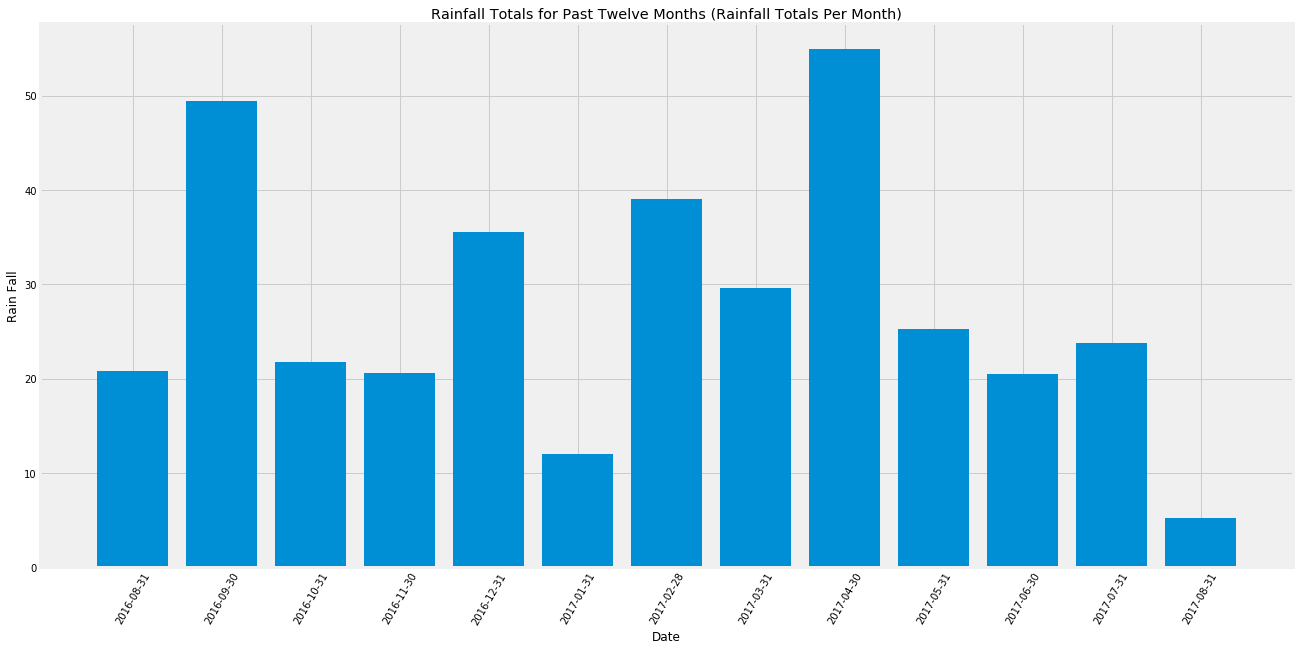

In [15]:
#prepping data to be plotted

#decided to add the prcp scores by month.
twelve = twelve.resample('M').sum()
twelve

tmd_sum = pd.DataFrame(twelve)
tmd_sum
tmd_sum = tmd_sum.reset_index()

#print(tmd_sum)

date = tmd_sum['date'].astype(str).tolist()
prcp = tmd_sum['prcp'].tolist()

#plotting
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(date,prcp)
ax.set_title("Rainfall Totals for Past Twelve Months (Rainfall Totals Per Month)")
plt.xticks(date,rotation=60)
ax.set_xlabel("Date")
ax.set_ylabel("Rain Fall")
plt.show()

In [16]:
#plotting again to look like example .png 

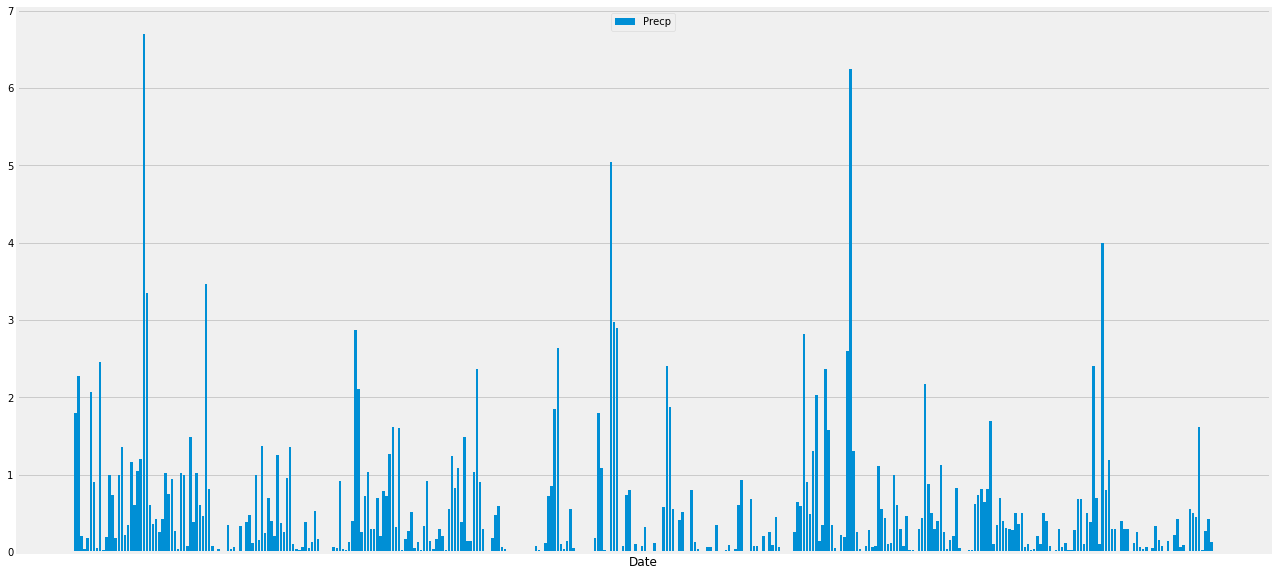

In [17]:
fig1, ax1 = plt.subplots(figsize=(20,10))

date1 = tmd['date'].astype(str).tolist()
prcp1 = tmd['prcp'].tolist()

ax1.bar(date1,prcp1)
plt.xlabel('Date')
#ax1.xaxis.set_visible(False)
ax1.set_xticks([])
ax1.legend(['Precp'],loc=9)
plt.show()


##### Use Pandas to calcualte the summary statistics for the precipitation data

In [18]:
tmd.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


##### Design a query to show how many stations are available in this dataset?


In [19]:
stations_count = pd.read_sql("Select count(distinct station) as '# Of Stations' from station" ,conn)
print(stations_count)
print(" ")
#or 

stations = session.query(func.count(Station.station)).all()
print(f'There are {stations} stations.')

   # Of Stations
0              9
 
There are [(9,)] stations.


##### What are the most active stations? (i.e. what stations have the most rows)?
###### List the stations and the counts in descending order.

In [20]:
stations = pd.read_sql("Select station,id, count(station) as 'Activity Count' from measurement group by station order by 3 desc",conn)
stations

,station,id,Activity Count
0,USC00519281,14959,2772
1,USC00519397,2724,2724
2,USC00513117,5433,2709
3,USC00519523,12187,2669
4,USC00516128,19550,2612
5,USC00514830,7635,2202
6,USC00511918,16938,1979
7,USC00517948,9007,1372
8,USC00518838,9518,511


##### Using the station id from the previous query, calculate the lowest temperature recorded, 
##### highest temperature recorded, and average temperature most active station?

In [21]:
#base overview of station table
stations = pd.read_sql('select * from Measurement',conn)
stations.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [22]:
#lowest temp
lowest_temp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

for row in lowest_temp[0]:
    print(f'The Lowest Temp for Sation USC00519281 is {row}')
    
#highest temp
highest_temp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

for row in highest_temp[0]:
    print(f'The Highest Temp for Sation USC00519281 is {row}')
    
#average temp
avg_temp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

for row in avg_temp[0]:
    print(f'The Average Temp for Sation USC00519281 is {row}')

The Lowest Temp for Sation USC00519281 is 54.0
The Highest Temp for Sation USC00519281 is 85.0
The Average Temp for Sation USC00519281 is 71.66378066378067


###### Choose the station with the highest number of temperature observations.

In [23]:
max_station = session.query(Measurement.date,Measurement.station,Measurement.tobs).\
        filter(Measurement.station == 'USC00519281').all()
max_station

[('2010-01-01', 'USC00519281', 70.0),
 ('2010-01-02', 'USC00519281', 62.0),
 ('2010-01-03', 'USC00519281', 74.0),
 ('2010-01-04', 'USC00519281', 75.0),
 ('2010-01-05', 'USC00519281', 74.0),
 ('2010-01-06', 'USC00519281', 76.0),
 ('2010-01-07', 'USC00519281', 69.0),
 ('2010-01-08', 'USC00519281', 66.0),
 ('2010-01-09', 'USC00519281', 70.0),
 ('2010-01-10', 'USC00519281', 75.0),
 ('2010-01-11', 'USC00519281', 64.0),
 ('2010-01-12', 'USC00519281', 60.0),
 ('2010-01-13', 'USC00519281', 61.0),
 ('2010-01-14', 'USC00519281', 68.0),
 ('2010-01-15', 'USC00519281', 64.0),
 ('2010-01-16', 'USC00519281', 66.0),
 ('2010-01-17', 'USC00519281', 67.0),
 ('2010-01-18', 'USC00519281', 70.0),
 ('2010-01-19', 'USC00519281', 67.0),
 ('2010-01-20', 'USC00519281', 67.0),
 ('2010-01-21', 'USC00519281', 69.0),
 ('2010-01-22', 'USC00519281', 60.0),
 ('2010-01-23', 'USC00519281', 75.0),
 ('2010-01-24', 'USC00519281', 75.0),
 ('2010-01-25', 'USC00519281', 65.0),
 ('2010-01-26', 'USC00519281', 75.0),
 ('2010-01-2


##### Query the last 12 months of temperature observation data for this station and plot the results as a histogram


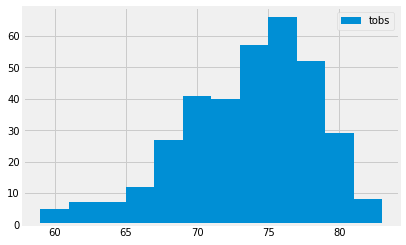

In [24]:
# extract only date from timestamp 
date_twelve = twelve_months_ago.date()
date_twelve

max_station_12 = session.query(Measurement.date,Measurement.station,Measurement.tobs).\
        filter(Measurement.station == 'USC00519281').\
        filter(Measurement.date > date_twelve).all()
#max_station_12

#plotting the results as a histogram

#extract temperature data 
hist_data = pd.DataFrame(max_station_12)

#plot that data
x = hist_data['tobs']
n_bins = 12


fig1, ax1 = plt.subplots()

ax1.hist(x, bins=n_bins)
ax1.legend()
plt.show()


### Temperature Analysis (Optional)

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [28]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [31]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [32]:
# Plot the daily normals as an area plot with `stacked=False`


# Testing querys for climate app

In [33]:
results = session.query(Measurement.date,Measurement.prcp).all()

weather_data = []
for weather in results:
    weather_dict = {}    
    weather_dict[weather.date] = weather.prcp
    weather_data.append(weather_dict)

#weather_data

In [34]:
stations = session.query(Station.station).all()

for row in stations:
    print (row)

('USC00519397',)
('USC00513117',)
('USC00514830',)
('USC00517948',)
('USC00518838',)
('USC00519523',)
('USC00519281',)
('USC00511918',)
('USC00516128',)


In [35]:
# query for the dates and temperature observations from a year from the last data point.
# Return a JSON list of Temperature Observations (tobs) for the previous year.



In [36]:
min_date = session.query(func.max(Measurement.date),func.min(Measurement.date)).all()

In [37]:
min_date[0]

('2017-08-23', '2010-01-01')

In [38]:

#   * When given the start only, calculate `TMIN`, `TAVG`, and `TMAX` for all dates greater than and equal to the start date.

# @app.route("/api/v1.0/<start>`")
def start(date):
    
    date = datetime.strptime(date, '%Y%m%d')
    date_ = date.date()
    
    min_max_avg_temp = session.query((Measurement.date),func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.date > date_).group_by(Measurement.date).all()
    
 
    
    avg_temp = session.query(func.min(Measurement.tobs).label('avg')).\
    filter(Measurement.date > date_).group_by(Measurement.date).all()
    
    data = list(np.ravel(min_max_avg_temp))
    
    return data
    
                               
                

In [39]:
start('201715')

['2017-01-06',
 '62.0',
 '74.0',
 '67.66666666666667',
 '2017-01-07',
 '66.0',
 '72.0',
 '70.16666666666667',
 '2017-01-08',
 '60.0',
 '74.0',
 '67.66666666666667',
 '2017-01-09',
 '62.0',
 '77.0',
 '67.71428571428571',
 '2017-01-10',
 '62.0',
 '75.0',
 '66.71428571428571',
 '2017-01-11',
 '63.0',
 '78.0',
 '69.33333333333333',
 '2017-01-12',
 '65.0',
 '81.0',
 '69.16666666666667',
 '2017-01-13',
 '67.0',
 '75.0',
 '69.33333333333333',
 '2017-01-14',
 '65.0',
 '77.0',
 '71.0',
 '2017-01-15',
 '66.0',
 '78.0',
 '69.8',
 '2017-01-16',
 '67.0',
 '80.0',
 '72.33333333333333',
 '2017-01-17',
 '66.0',
 '75.0',
 '70.5',
 '2017-01-18',
 '72.0',
 '75.0',
 '73.28571428571429',
 '2017-01-19',
 '66.0',
 '78.0',
 '72.85714285714286',
 '2017-01-20',
 '67.0',
 '74.0',
 '71.0',
 '2017-01-21',
 '67.0',
 '74.0',
 '71.5',
 '2017-01-22',
 '68.0',
 '74.0',
 '71.2',
 '2017-01-23',
 '70.0',
 '77.0',
 '73.0',
 '2017-01-24',
 '67.0',
 '74.0',
 '70.33333333333333',
 '2017-01-25',
 '69.0',
 '73.0',
 '71.0',
 '20

In [40]:
def start_date(start,end):

    start = datetime.strptime(start, '%Y%m%d')
    start_date = start.date()

    end = datetime.strptime(end, '%Y%m%d')
    end_date = end.date()
    
    min_max_avg_temp = session.query((Measurement.date),func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.date >= start_date).group_by(Measurement.date).\
    filter(Measurement.date <= end_date).all()
    
    data = list(np.ravel(min_max_avg_temp))
    
    print(data)

In [41]:
start_date('201055','201057')

['2010-05-05', '71.0', '78.0', '74.0', '2010-05-06', '71.0', '80.0', '73.875', '2010-05-07', '68.0', '75.0', '71.42857142857143']
